## Evaluation of Experiments

In this notebook the experiments are evaluated for the RS paper 

Set up envornmental variables:

In [1]:
import tensorflow as tf
import os
import re
import glob

In [3]:
savedir = r"E:\acocac\research\paper\models\bands\models\1epoch"

r = [8, 16,32,64]
l = [1,2,3]
p = ['unidir','bidir']

dataset = "test"
rolling_mean_window = 5

def params2name(l,r,p):
    return "convgru{}_p24pxk0px_batch8_09_MCD12Q1v6_cleaned_8d_l{}_{}".format(r,l,p)

runs = [] # expected runs
for r_ in r:
    for l_ in l:
        for p_ in p:
            runs.append(params2name(l_,r_,p_))

extract data from Tensorflow event files:

walk through all event files and extract cross entropy:

In [4]:
def extract_from_eventfile(eventfile_path, tag):
    steps = []
    values = []

    for e in tf.train.summary_iterator(eventfile_path):
        for v in e.summary.value:
            if v.tag == tag:
                steps.append(e.step)
                values.append(v.simple_value)

    return steps, values

def extract_from_all_eventfiles(path, target, tag):
    """ 
    appends values from all event files in one folder
    if path does not exist: returns empty list
    """
    steps = []
    values = []
    
    if os.path.exists(path):
        eventfiles = glob.glob(os.path.join(path,target,'*.ATLANTIC'))
    else:
        return steps, values # empty
    
    for eventfile in eventfiles:
        steps_,values_ = extract_from_eventfile(os.path.join(path,eventfile), tag=tag)
        steps.extend(steps_)
        values.extend(values_)
        
    return steps, values

def gather_data_from_multiple_runs(folder_path, runs, dataset="test2009", tag='xe'):
    """
    look through all save folders defined by runs, extract eventfiles from runs
    and append everything to pandas dataframe
    """

    series = []
    for run in runs:
        path = os.path.join(folder_path,run)
        steps,values = extract_from_all_eventfiles(path, dataset, tag)
        print("run: {} extracted {} values".format(run,len(values)))   

        if len(values) > 0:

            s = pd.Series(data=values, index=steps,name=run).sort_index()
            # drop duplicates
            s = s[~s.index.duplicated(keep='last')]

            #.drop_duplicates(keep='last')
            series.append(s)
            
    return pd.concat(series,axis=1,join="outer")

In [5]:
import pandas as pd
import numpy as np

def smooth_and_interpolate(data, rolling_mean_window = 10):
    data.interpolate(axis=1,inplace=True)
    return data.rolling(window=rolling_mean_window,axis=0).mean()

def get_best_run(data,max_is_better=False):
    scores = []
    for col in data.columns: 
        s = data[col]
        scores.append(s.loc[s.last_valid_index()])
    
    if max_is_better:
        return data.columns[np.array(scores).argmax()]
    else:
        return data.columns[np.array(scores).argmin()]

dataset = 'test2009'

# cross entropy
tag='xe'
data = gather_data_from_multiple_runs(savedir,runs,'test2009',tag)
data_smooth = smooth_and_interpolate(data,rolling_mean_window)

run: convgru8_p24pxk0px_batch8_09_MCD12Q1v6_cleaned_8d_l1_unidir extracted 0 values
run: convgru8_p24pxk0px_batch8_09_MCD12Q1v6_cleaned_8d_l1_bidir extracted 209 values
run: convgru8_p24pxk0px_batch8_09_MCD12Q1v6_cleaned_8d_l2_unidir extracted 0 values
run: convgru8_p24pxk0px_batch8_09_MCD12Q1v6_cleaned_8d_l2_bidir extracted 209 values
run: convgru8_p24pxk0px_batch8_09_MCD12Q1v6_cleaned_8d_l3_unidir extracted 0 values
run: convgru8_p24pxk0px_batch8_09_MCD12Q1v6_cleaned_8d_l3_bidir extracted 210 values
run: convgru16_p24pxk0px_batch8_09_MCD12Q1v6_cleaned_8d_l1_unidir extracted 0 values
run: convgru16_p24pxk0px_batch8_09_MCD12Q1v6_cleaned_8d_l1_bidir extracted 209 values
run: convgru16_p24pxk0px_batch8_09_MCD12Q1v6_cleaned_8d_l2_unidir extracted 0 values
run: convgru16_p24pxk0px_batch8_09_MCD12Q1v6_cleaned_8d_l2_bidir extracted 209 values
run: convgru16_p24pxk0px_batch8_09_MCD12Q1v6_cleaned_8d_l3_unidir extracted 0 values
run: convgru16_p24pxk0px_batch8_09_MCD12Q1v6_cleaned_8d_l3_bidir e

### Plot cross entropy over time for all networks

In [6]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch
from matplotlib.colors import rgb2hex
%matplotlib inline
import seaborn as sns
import numpy as np

# sns.set(context='notebook', style='whitegrid', palette='deep', font='Times', font_scale=1, color_codes=False, rc=None)

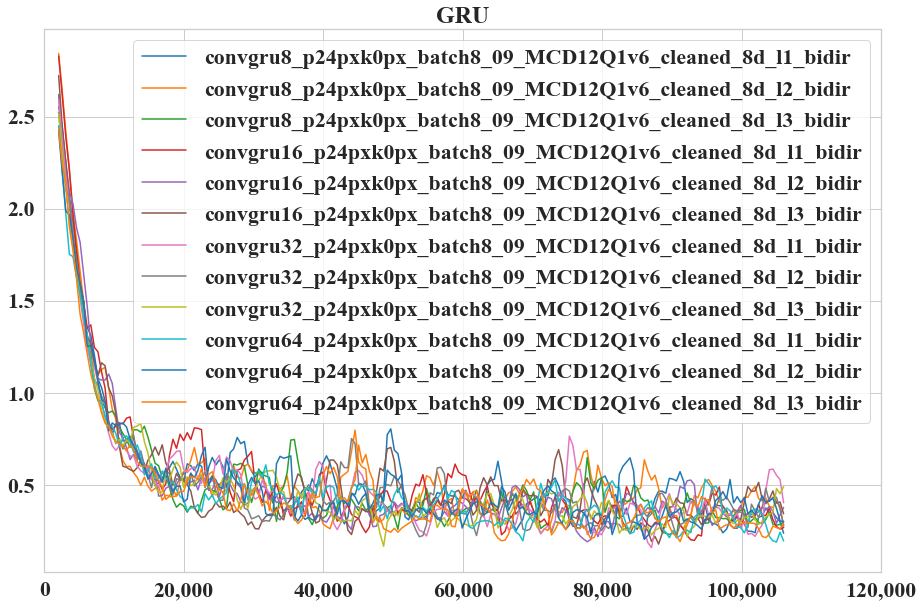

In [7]:
def plot_all_runs(data, ax=None, col="#cccccc", std_alpha=0.5, title="title"):
    if ax is None:
        f, ax = plt.subplots()
    
    runs = data.columns
    for run in runs:
        mask = np.isfinite(data[run])
        ax.plot(data[run][mask],label=run)

#     ax.fill_between(mean.index, mean-std, mean+std, where=mean+std >= mean-std, interpolate=True, facecolor=col, alpha=std_alpha, label=label_std)
    
    # xlabels
    ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    ax.set_xlim(0,120000)
    ax.set_title(title)
    
    return ax

with plt.rc_context(dict(sns.axes_style("whitegrid"),
                         **sns.plotting_context("notebook", font_scale=2))):
    
    sns.set_style({'font.family': 'Times New Roman'})

    figsize=(15,10)
    f, ax = plt.subplots(figsize=figsize)
    plot_all_runs(data_smooth, ax=ax, col="#cccccc", std_alpha=0.5, title='GRU')
    ax.legend()

### Check completeness of training

Extract indeces of first event and last event for all networks to test if the networks have all trained completely

In [19]:
out = []
for run in runs:
    if run in data.columns:
        col = data[run]
        first_valid = col.first_valid_index()
        last_valid = col.last_valid_index()
    else:
        first_valid = None
        last_valid = None

    out.append({"run":run, "first_valid":first_valid, "last_valid":last_valid})

check_df = pd.DataFrame(out).set_index("run")
# first_valid_by_network = d.pivot(columns='network', values='first_valid')
# last_valid_by_network = d.pivot(columns='network', values='last_valid')

In [20]:
check_df

,first_valid,last_valid
run,,
convgru8_p24pxk0px_batch8_09_MCD12Q1v6_cleaned_8d_l1_monodir,8,105992
convgru8_p24pxk0px_batch8_09_MCD12Q1v6_cleaned_8d_l1_bidir,8,105992
convgru8_p24pxk0px_batch8_09_MCD12Q1v6_cleaned_8d_l2_monodir,8,105992
convgru8_p24pxk0px_batch8_09_MCD12Q1v6_cleaned_8d_l2_bidir,8,105992
convgru8_p24pxk0px_batch8_09_MCD12Q1v6_cleaned_8d_l3_monodir,8,105992
convgru8_p24pxk0px_batch8_09_MCD12Q1v6_cleaned_8d_l3_bidir,8,105992
convgru16_p24pxk0px_batch8_09_MCD12Q1v6_cleaned_8d_l1_monodir,8,105992
convgru16_p24pxk0px_batch8_09_MCD12Q1v6_cleaned_8d_l1_bidir,8,105992
convgru16_p24pxk0px_batch8_09_MCD12Q1v6_cleaned_8d_l2_monodir,8,105992


### Plots of LSTM layers
by number of layers l
and number if cells per layer r

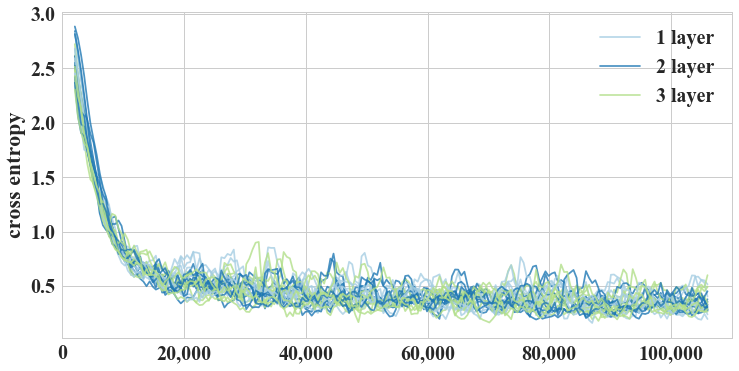

In [25]:
cols = sns.color_palette("Paired", n_colors=len(l))

colormapping = dict(zip(l,cols))

def plot_by_l(data, colormapping, ax=None, cols=["blue","green","red"]):
    """
        Plot multilpe networks sorted by number of cells r
    """
    if ax is None:
        f, ax = plt.subplots()
    
    labels = ["{} layer".format(l_) for l_ in colormapping.keys()]
    labels_map = dict(zip(colormapping.keys(),labels))
    
    runs = data.columns
    for run in runs:
        regex = r'_l(\d+)'
        l = re.findall(regex, run)[0]
        col = colormapping[int(l)]
        mask = np.isfinite(data[run])
        ax.plot(data[run][mask], color=col, label=labels_map[int(l)], alpha=0.8)
        labels_map[int(l)] = ""
    
    # xlabels
    ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    ax.set_ylabel("cross entropy")
    
    ax.set_xlim(0,110000)
    
    return ax

with plt.rc_context(dict(sns.axes_style("whitegrid"),
                         **sns.plotting_context("notebook", font_scale=2))):
    
    sns.set_style({'font.family': 'Times New Roman'})
    
    f, ax = plt.subplots(figsize=(12,6))
    plot_by_l(data_smooth, colormapping,ax=ax)
    ax.legend()

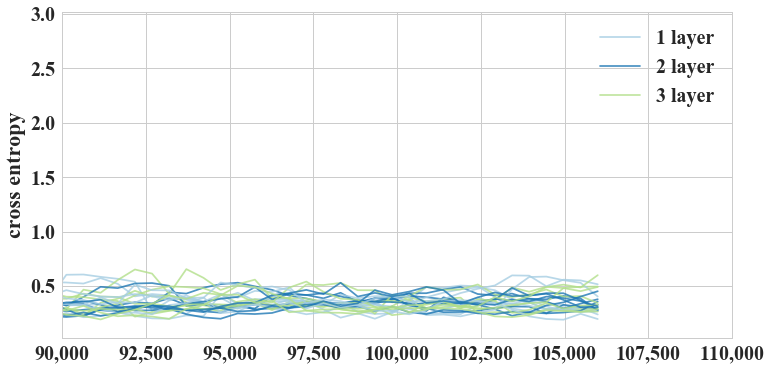

In [32]:
cols = sns.color_palette("Paired", n_colors=len(l))

colormapping = dict(zip(l,cols))

def plot_by_l(data, colormapping, ax=None, cols=["blue","green","red"]):
    """
        Plot multilpe networks sorted by number of cells r
    """
    if ax is None:
        f, ax = plt.subplots()
    
    labels = ["{} layer".format(l_) for l_ in colormapping.keys()]
    labels_map = dict(zip(colormapping.keys(),labels))
    
    runs = data.columns
    for run in runs:
        regex = r'_l(\d+)'
        l = re.findall(regex, run)[0]
        col = colormapping[int(l)]
        mask = np.isfinite(data[run])
        ax.plot(data[run][mask], color=col, label=labels_map[int(l)], alpha=0.8)
        labels_map[int(l)] = ""
    
    # xlabels
    ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    ax.set_ylabel("cross entropy")
    
    ax.set_xlim(90000,110000)
    
    return ax

with plt.rc_context(dict(sns.axes_style("whitegrid"),
                         **sns.plotting_context("notebook", font_scale=2))):
    
    sns.set_style({'font.family': 'Times New Roman'})
    
    f, ax = plt.subplots(figsize=(12,6))
    plot_by_l(data_smooth, colormapping,ax=ax)
    ax.legend()

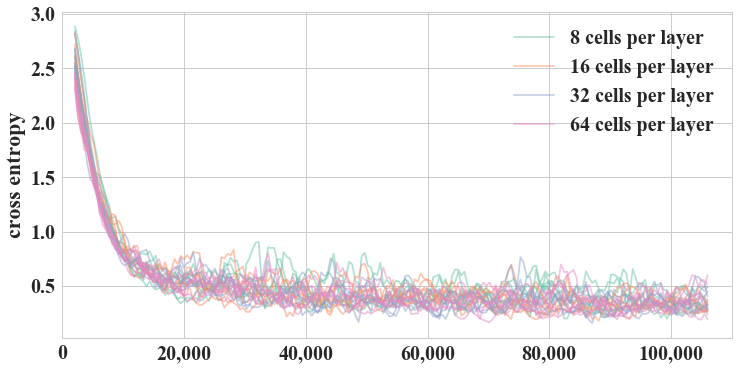

In [26]:
cols = sns.color_palette("Set2", n_colors=len(r))

colormapping = dict(zip(r,cols))

def plot_by_r(data, colormapping, ax=None, cols=["blue","green","red"]):
    """
        Plot multilpe networks sorted by number of cells r
    """
    if ax is None:
        f, ax = plt.subplots()
    
    labels = ["{} cells per layer".format(r_) for r_ in colormapping.keys()]
    labels_map = dict(zip(colormapping.keys(),labels))
    
    runs = data.columns
    for run in runs:
        regex = r'convgru(\d+)'
        r = re.findall(regex, run)[0]
        col = colormapping[int(r)]
        mask = np.isfinite(data[run])
        ax.plot(data[run][mask], color=col, label=labels_map[int(r)], alpha=0.5)
        labels_map[int(r)] = ""
    
    # xlabels
    ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    ax.set_ylabel("cross entropy")
    
    ax.set_xlim(0,110000)
    
    return ax

with plt.rc_context(dict(sns.axes_style("whitegrid"),
                         **sns.plotting_context("notebook", font_scale=2))):
    
    sns.set_style({'font.family': 'Times New Roman'})
    
    f, ax = plt.subplots(figsize=(12,6))
    plot_by_r(data_smooth, colormapping,ax=ax)
    ax.legend()

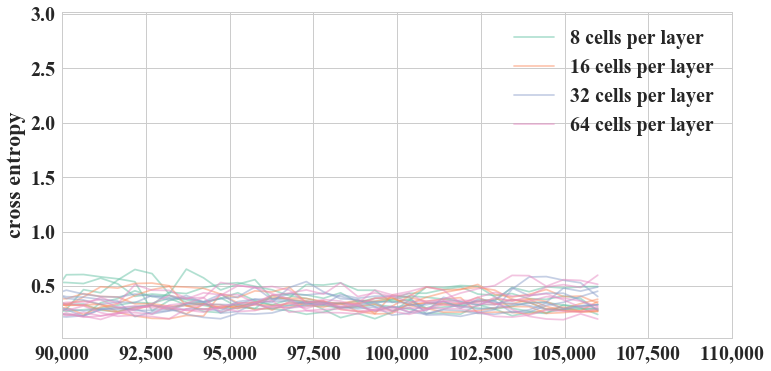

In [30]:
cols = sns.color_palette("Set2", n_colors=len(r))

colormapping = dict(zip(r,cols))

def plot_by_r(data, colormapping, ax=None, cols=["blue","green","red"]):
    """
        Plot multilpe networks sorted by number of cells r
    """
    if ax is None:
        f, ax = plt.subplots()
    
    labels = ["{} cells per layer".format(r_) for r_ in colormapping.keys()]
    labels_map = dict(zip(colormapping.keys(),labels))
    
    runs = data.columns
    for run in runs:
        regex = r'convgru(\d+)'
        r = re.findall(regex, run)[0]
        col = colormapping[int(r)]
        mask = np.isfinite(data[run])
        ax.plot(data[run][mask], color=col, label=labels_map[int(r)], alpha=0.5)
        labels_map[int(r)] = ""
    
    # xlabels
    ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    ax.set_ylabel("cross entropy")
    
    ax.set_xlim(90000,110000)
    
    return ax

with plt.rc_context(dict(sns.axes_style("whitegrid"),
                         **sns.plotting_context("notebook", font_scale=2))):
    
    sns.set_style({'font.family': 'Times New Roman'})
    
    f, ax = plt.subplots(figsize=(12,6))
    plot_by_r(data_smooth, colormapping,ax=ax)
    ax.legend()

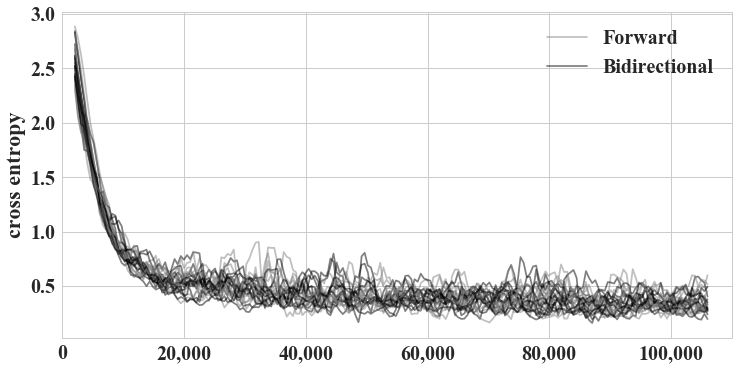

In [27]:
colormapping = {  'monodir':"gray",
                  'bidir':"black"}

def plot_by_l(data, colormapping, ax=None, cols=["blue","green","red"]):
    if ax is None:
        f, ax = plt.subplots()
    
    runs = data.columns
    for run in runs:
        p = run.split('_')[-1]
        col = colormapping[p]
        mask = np.isfinite(data[run])
        ax.plot(data[run][mask], color=col, alpha=0.5)
    
    # xlabels
    ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    ax.set_ylabel("cross entropy")
    
    ax.set_xlim(0,110000)
    
    return ax

with plt.rc_context(dict(sns.axes_style("whitegrid"),
                         **sns.plotting_context("notebook", font_scale=2))):
    
    sns.set_style({'font.family': 'Times New Roman'})
    
    f, ax = plt.subplots(figsize=(12,6))
    plot_by_l(data_smooth, colormapping,ax=ax)
    ax.legend(["Forward", "Bidirectional"])

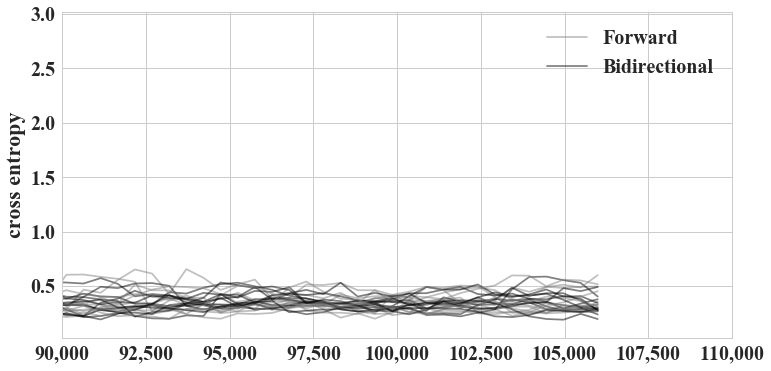

In [29]:
colormapping = {  'monodir':"gray",
                  'bidir':"black"}

def plot_by_l(data, colormapping, ax=None, cols=["blue","green","red"]):
    if ax is None:
        f, ax = plt.subplots()
    
    runs = data.columns
    for run in runs:
        p = run.split('_')[-1]
        col = colormapping[p]
        mask = np.isfinite(data[run])
        ax.plot(data[run][mask], color=col, alpha=0.5)
    
    # xlabels
    ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    ax.set_ylabel("cross entropy")
    
    ax.set_xlim(90000,110000)
    
    return ax

with plt.rc_context(dict(sns.axes_style("whitegrid"),
                         **sns.plotting_context("notebook", font_scale=2))):
    
    sns.set_style({'font.family': 'Times New Roman'})
    
    f, ax = plt.subplots(figsize=(12,6))
    plot_by_l(data_smooth, colormapping,ax=ax)
    ax.legend(["Forward", "Bidirectional"])